In [1]:
#Load all the libraries
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
random_state=42
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Use this function that Brian so graceously gave me that uses reddit's API to bring in subreddit posts and comments.
#subreddit says what subreddit you want to bring in and kind is if you are looking for posts or comments.
#skip is the amount of days you are searching for and times is the amount of times you are searching for data
#They come in as a dataframe only if the response code is 200
#Have sleep set as 2 seconds so there is a second wait in between each time you grab data
def query_pushshift(subreddit, kind='submission', skip=30, times=10, 
                    subfield = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self'],
                    comfields = ['body', 'score', 'created_utc']):

    #Size is trying to pull 500 results per pull
    stem = "https://api.pushshift.io/reddit/search/{}/?subreddit={}&size=500".format(kind, subreddit)
    mylist = []
    
    for x in range(1, times):
        
        URL = "{}&after={}d".format(stem, skip * x)
        print(URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        mylist.append(df)
        time.sleep(2)
        
    full = pd.concat(mylist, sort=False)
    
    if kind == "submission":
        
        full = full[subfield]
        
        full = full.drop_duplicates()
        
        full = full.loc[full['is_self'] == True]
        
    def get_date(created):
        return dt.date.fromtimestamp(created)
    
    _timestamp = full["created_utc"].apply(get_date)
    
    full['timestamp'] = _timestamp

    print(full.shape)
    
    return full

In [3]:
#Bring in the datasets you loaded in the other notebook.
df_curb_post = pd.read_csv('./datasets/curb_post_all.csv')
df_seinfeld_post = pd.read_csv('./datasets/seinfeld_post_all.csv')
df_curb_comment = pd.read_csv('./datasets/curb_comment.csv')
df_seinfeld_comment = pd.read_csv('./datasets/seinfeld_comment.csv')

In [4]:
#Creates a function that cleans the data into a dataset for nlp.
def clean_post(df):
    #for all na values just put in spaces
    df.fillna(' ', inplace=True)
    #Cleans the post dataframes so that you combine the title and selftext column into a new column called title.
    if 'title' in df.columns:
        df['body'] = df['title'].str.cat(df['selftext'], sep=' ')
    #if title column doesn't exist then do nothing
    else:
        None
    #make the dataframe equal to just the body and subreddit columns
    df = df[['body', 'subreddit']]
    #reset the index for the dataframe
    df = df.reset_index()
    #taken from https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
    #get rid of all web addresses from body column and I used the website above to assist in my coding
    df['body'] = df['body'].str.replace('http\S+|www.\S+', '', case=False)
    #return the edited dataframe
    return df

In [5]:
#clean the data for each of our dataframees
df_curb_post = clean_post(df_curb_post)
df_curb_comment = clean_post(df_curb_comment)
df_seinfeld_post = clean_post(df_seinfeld_post)
df_seinfeld_comment = clean_post(df_seinfeld_comment)

In [6]:
#reset the indexes for each of our dataframes
df_posts = pd.concat([df_curb_post, df_seinfeld_post]).reset_index()
df_combined = pd.concat([df_curb_post, df_curb_comment, df_seinfeld_post, df_seinfeld_comment]).reset_index()
#Just look at the body and subreddit columns
df_posts = df_posts[['body', 'subreddit']]
df_combined = df_combined[['body', 'subreddit']]

In [7]:
#make a new column that is a binary column that tells if the show is seinfeld(1) or curb (0).
df_posts['sub_reddit_binary'] = df_posts['subreddit'].map({'curb': 0, 'seinfeld': 1})
df_combined['sub_reddit_binary'] = df_combined['subreddit'].map({'curb': 0, 'seinfeld': 1})

In [8]:
import nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
#Create a function that gets rid of any characters that are not english alphabet characters
def just_letters(text):
    return [re.sub("[^a-zA-Z]", " ", w) for w in w_tokenizer.tokenize(text)]

In [9]:
#apply the function created above to the dataframe with posts and posts and comments and create this in a new column, body_letters.
df_posts['body_letters'] = df_posts['body'].apply(just_letters)
df_combined['body_letters'] = df_combined['body'].apply(just_letters)

In [10]:
#Drop all instances of the word deleted and removed from the body column. 
#This works since they are now seperated by columns.
df_posts = df_posts.drop(df_posts[df_posts['body'].str.contains("deleted")].index)
df_posts = df_posts.drop(df_posts[df_posts['body'].str.contains("removed")].index)
df_combined = df_combined.drop(df_combined[df_combined['body'].str.contains("deleted")].index)
df_combined = df_combined.drop(df_combined[df_combined['body'].str.contains("removed")].index)

In [11]:
#https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells
#Creates a model that lemmatizes the words in my model to limit the amounts of different words I have
#This is good to do for my data so I am not looking at different versions of the same words.
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [12]:
#apply the lemmatize function to our body_letters column and join them together to get rid of the commas
df_posts['body'] = df_posts['body_letters'].apply(lemmatize_text).apply(" ".join)
df_combined['body'] = df_combined['body_letters'].apply(lemmatize_text).apply(" ".join)

In [13]:
#Found that these functions do not help my model but actually hurt it

# def no_larry(text):
#     return [re.sub(r'[Ll]arry', ' ', text)]

# def no_david(text):
#     return [re.sub(r'[Dd]avid', ' ', text)]

# def no_seinfeld(text):
#     return [re.sub(r'[Ss]einfeld', ' ', text)]

In [14]:
#Creates a function to get rid of the word episode from my data since this does not give any information on which show.
def no_episode(text):
    return [re.sub(r'[Ee]pisode', ' ', text)]

In [15]:
#apply the no_episode function to our body_letters column and join them together to get rid of the commas
df_posts['body'] = df_posts['body'].apply(no_episode).apply(" ".join)
df_combined['body'] = df_combined['body'].apply(no_episode).apply(" ".join)

In [16]:
#observe the baseline percentage for the amount of seinfeld posts vs curb posts.
#We can see our classes are pretty balanced
#We would want our data to be substantially higher than 50 percent
df_posts['sub_reddit_binary'].value_counts(normalize=True)

1    0.514186
0    0.485814
Name: sub_reddit_binary, dtype: float64

In [17]:
#observe the baseline percentage for the amount of seinfeld posts and comments vs curb posts and comments.
#We can see our classes are pretty balanced even more so than the dataframe with just the posts.
#We would want our data to be substantially higher than 50 percent
df_combined['sub_reddit_binary'].value_counts(normalize=True)

1    0.502732
0    0.497268
Name: sub_reddit_binary, dtype: float64

## Models with Posts Only

### Count Vectorizer with Logistic Regression

In [18]:
#set up my X as the body of the text and my y as the binary column of the subreddit
X = df_posts['body']
y = df_posts['sub_reddit_binary']

In [19]:
#Conduct a train test split of our data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [20]:
#Conduct a model with count vectorizer and logistic regression to model with no parameters being changed
#I chose to not change any parameters so that I can set a baseline model and see if Naive Bayes or Random Forest can improve upon that model
pipe_cv_ls = Pipeline([
    ('cv', CountVectorizer()),
    ('ls', LogisticRegression(n_jobs=-1))
])
pip_cv_ls_params = {}

In [21]:
#Fit my model
grid = GridSearchCV(pipe_cv_ls, pip_cv_ls_params)
grid.fit(X_train, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/envs/dsi/l

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
#find our y_hat's which are our predicted values
y_hat = grid.predict(X_test)

In [23]:
#look at the confusion matrix which shows we have more false negatives than false positives
confusion_matrix(y_hat, y_test)

array([[198,  22],
       [ 46, 237]])

In [24]:
#Look at the train score
grid.score(X_train, y_train)

0.9953519256308101

In [25]:
#Compare the test score. You can see that my logistic model is clearly overfit with a 12% difference between train and test.
grid.score(X_test, y_test)

0.8648111332007953

### TFIDF Vectorizer with Niave Bayes

In [26]:
#Create a pipeline for a model that vectorizes using TFIDF and naive bayes using multinomial distribution
pipe_tv_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

#use parameters that look at TFIDF the amount of ngrams, look at no and english stop words, look at max features at none, 500
# and 1500. Look at naive bayes with alphas of .1, 1 and 10
pip_tv_nb_params = {
    'tvec__ngram_range': ((1, 1), (1, 2)),
    'tvec__stop_words': (None, 'english'),
    'tvec__max_features': (None, 500, 1500),
    'nb__alpha': [.1, 1, 10],
    
}

In [27]:
#Do a gridsearch and fit my model
grid_nb = GridSearchCV(pipe_tv_nb, pip_tv_nb_params)
grid_nb.fit(X_train, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__ngram_range': ((1, 1), (1, 2)), 'tvec__stop_words': (None, 'english'), 'tvec__max_features': (None, 500, 1500), 'nb__alpha': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
#Look at my best parameters and you can see that most of the default ones work best except that alpha works best as 10
grid_nb.best_params_

{'nb__alpha': 10,
 'tvec__max_features': None,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [29]:
#Look at the train score which we can see went down from the logistic model, which is good
grid_nb.score(X_train, y_train)

0.9860557768924303

In [30]:
#the testing score is higher for naive bayes and less overfit
grid_nb.score(X_test, y_test)

0.8946322067594433

In [31]:
#create our predictions
y_hat = grid_nb.predict(X_test)

In [32]:
#Look at the confusion matrix. There are more false positives and less false negatives
confusion_matrix(y_hat, y_test)

array([[215,  24],
       [ 29, 235]])

### TFIDF Vectorizer with Random Forest Classification Model

In [33]:
#Create a pipeline for a model that vectorizes using TFIDF and Random Forest classification
pipe_tv_rf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(n_jobs=-1, max_features='sqrt'))
])

#use parameters that look at TFIDF look at max features at 1000 and 1100
# and 1500. Look at random forest with n_estimators of 400 and 2000
pip_tv_rf_params = {
    'tvec__max_features': (1000, 1100),
    'rf__n_estimators': (400, 2000)
   
    
    
}

In [34]:
#Do a gridsearch and fit my model
grid_rf = GridSearchCV(pipe_tv_rf, pip_tv_rf_params)
grid_rf.fit(X_train, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__max_features': (1000, 1100), 'rf__n_estimators': (400, 2000)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
#Look at my best parameters and can see that n_estimators of 2000 and max_features of 1000 work best
grid_rf.best_params_

{'rf__n_estimators': 2000, 'tvec__max_features': 1000}

In [36]:
#get my predicted values
y_hat = grid_rf.predict(X_test)

In [37]:
#Significantly decreases my false positives.
confusion_matrix(y_hat, y_test)

array([[202,  17],
       [ 42, 242]])

In [38]:
#My training score remains high like the logistic regression
grid_rf.score(X_train, y_train)

0.99800796812749

In [39]:
#I can see that my random forest score is above 90 percent but is still below the testing score for Naive Bayes
grid_rf.score(X_test, y_test)

0.882703777335984

In [40]:
#https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
#used code I found on medium to create a list of the top 10 most frequent words in my training data
def get_top_n_words(corpus, n=None):
#     List the top n words in a vocabulary according to occurrence in a text corpus.
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


pop_words = get_top_n_words(X_train, n=10)


words_freq =[]
freq_num = []
for word, freq in pop_words:
    words_freq.append(word)
    freq_num.append(freq)
    

    dic = {'Word': words_freq, 'Frequency': freq_num}
top_words = pd.DataFrame(dic)

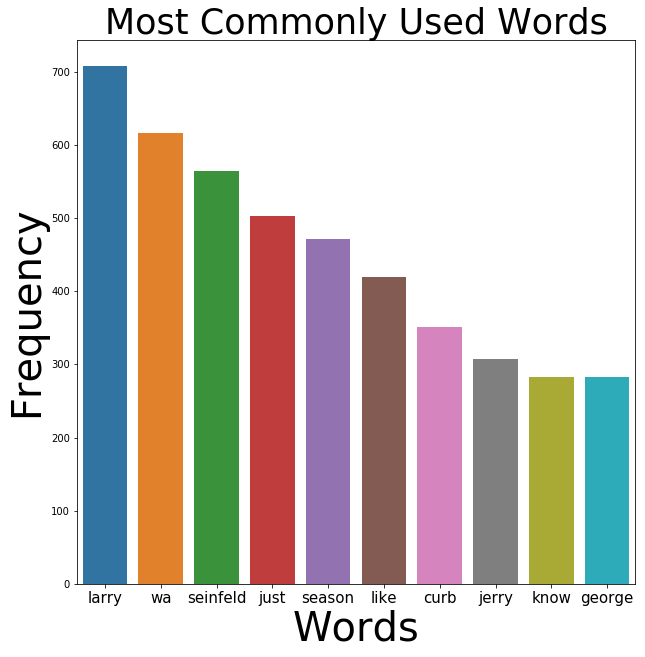

In [41]:
#Plot that shows the most frequently used words and how many occurences they had.
plt.figure(figsize=(10,10))
sns.barplot(top_words['Word'], top_words['Frequency'])
plt.title('Most Commonly Used Words', size = 35)
plt.xlabel('Words', size = 40)
plt.ylabel('Frequency', size = 40)
plt.xticks(size = 15);

## Model with Posts and Comments

### Count Vectorizer with Logistic Regression

In [42]:
#set up my X as the body of the text and my y as the binary column of the subreddit
X = df_combined['body']
y = df_combined['sub_reddit_binary']

In [43]:
#Conduct a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [44]:
#Conduct a model with count vectorizer and logistic regression to model with no parameters being changed
#I chose to not change any parameters so that I can set a baseline model and see if Naive Bayes or Random Forest can improve upon that model
pipe_cv_ls = Pipeline([
    ('cv', CountVectorizer()),
    ('ls', LogisticRegression(n_jobs=-1))
])
pip_cv_ls_params = {}

In [45]:
#Fit my model
grid_ls = GridSearchCV(pipe_cv_ls, pip_cv_ls_params)
grid_ls.fit(X_train, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/envs/dsi/l

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
#make my predictions
y_hat = grid_ls.predict(X_test)

In [47]:
#Look at my confusion matrix; there are more false negatives than false positives.
confusion_matrix(y_hat, y_test)

array([[1003,  218],
       [ 362, 1163]])

In [48]:
#Look at my training score 
grid_ls.score(X_train, y_train)

0.9304273919378339

In [49]:
#Look at my testing score; test score is more overfit when compared to the mode with just the posts
grid_ls.score(X_test, y_test)

0.7887836853605243

### TFIDF Vectorizer with Niave Bayes

In [50]:
#Create a pipeline for a model that vectorizes using TFIDF and naive bayes using multinomial distribution
pipe_tv_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

#use parameters that look at TFIDF the amount of ngrans, look at no and english stop words, look at max features at none, 500
# and 1500. Look at naive bayes with alphas of .1, 1 and 10
pip_tv_nb_params = {
    'tvec__ngram_range': ((1, 1), (1, 2)),
    'tvec__stop_words': (None, 'english'),
    'tvec__max_features': (None, 500, 1500),
    'nb__alpha': [.1, 1, 10],
    
}

In [51]:
#Fit my model
grid_nb = GridSearchCV(pipe_tv_nb, pip_tv_nb_params)
grid_nb.fit(X_train, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__ngram_range': ((1, 1), (1, 2)), 'tvec__stop_words': (None, 'english'), 'tvec__max_features': (None, 500, 1500), 'nb__alpha': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
#Look at my best parameters. ngram range of 1, 2 and english stop words appears to work better than the default
grid_nb.best_params_

{'nb__alpha': 0.1,
 'tvec__max_features': None,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [53]:
#Look at my train score
grid_nb.score(X_train, y_train)

0.9737736765420106

In [54]:
#This appears to work better than the Logistic model.
#This is interesting because for the data with just posts Naive Bayes worked worse
grid_nb.score(X_test, y_test)

0.8106336489439184

In [55]:
#Look at my predictions
y_hat = grid_nb.predict(X_test)

In [56]:
#Naive Bayes decreased my false negatives but increased my false positives
confusion_matrix(y_hat, y_test)

array([[1130,  285],
       [ 235, 1096]])

### TFIDF Vectorizer with Random Forest Classification Model

In [57]:
#Create a pipeline for a model that vectorizes using TFIDF and Random Forest classification
pipe_tv_rf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(n_jobs=-1, max_features='sqrt'))
])

#use parameters that look at TFIDF look at max features at 1000 and 1100
# and 1500. Look at random forest with n_estimators of 400 and 2000
pip_tv_rf_params = {
    'tvec__max_features': (1000, 1100),
    'rf__n_estimators': (400, 2000)
   
    
    
}

In [58]:
#Fit my data
grid_rf = GridSearchCV(pipe_tv_rf, pip_tv_rf_params)
grid_rf.fit(X_train, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__max_features': (1000, 1100), 'rf__n_estimators': (400, 2000)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
#Find my best parameters, n_estimators is best at 2000 and max_features works best at 1100
grid_rf.best_params_

{'rf__n_estimators': 400, 'tvec__max_features': 1100}

In [60]:
#Creating my predictions
y_hat = grid_rf.predict(X_test)

In [61]:
#Looking at my confusion matrix
#This model increases both my false negatives and false positives compared to my logistic regression
confusion_matrix(y_hat, y_test)

array([[ 970,  270],
       [ 395, 1111]])

In [62]:
#Look at my training scores
grid_rf.score(X_train, y_train)

0.9273919378339

In [63]:
#Look at my testing scores
#You can see while Random Forest worked best with just posts it has worked the worst with posts and comments
grid_rf.score(X_test, y_test)

0.7578295702840495

By looking at models with posts and models with posts and comments I have seen that the models with posts and comments are much more overfit than the models with just posts.